# **K2 Data Science - EDA Project** 

*NYC Rental Listing Data*

First, import the libraries that will be used.

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", palette="deep")
import folium
import csv
from geopy.geocoders import Nominatim
geolocator = Nominatim()
from geopy.distance import vincenty
from geopy.exc import GeocoderTimedOut
import time
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

In [2]:
#bring in data and reset index
train = pd.read_json('train_df.json').reset_index(drop=True)
#train = pd.read_csv('train_df.csv')
train.shape

(49352, 17)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 17 columns):
bathrooms              49352 non-null float64
bedrooms               49352 non-null int64
building_id            49352 non-null object
closest_subway_dist    49352 non-null float64
created                49352 non-null object
description            49352 non-null object
display_address        49352 non-null object
features               49352 non-null object
interest_level         49352 non-null object
latitude               49352 non-null float64
listing_id             49352 non-null int64
longitude              49352 non-null float64
manager_id             49352 non-null object
photos                 49352 non-null object
pos                    49352 non-null object
price                  49352 non-null int64
street_address         49352 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 6.4+ MB


In [4]:
#capitalize interest_level variable for looks
up = lambda x: x.upper()
train['interest_level'] = train['interest_level'].apply(up, 1)

In [5]:
def int_level_num(x):
    if x == 'LOW':
        return int(0)
    elif x == 'MEDIUM':
        return int(1)
    elif x == 'HIGH':
        return int(2)

In [6]:
train['int_level_num'] = train['interest_level'].apply(int_level_num)

In [7]:
#bring in subway station lat-lon
subway = pd.read_csv('subway_stations.csv')
#bring in csv table with NY neighborhoods and their corresponding zip codes
zips = pd.read_csv('NYC_zip.csv')
#bring in previously created table with lat-lon and zip codes
cdf_final = pd.read_csv('coord_final.csv')

In [8]:
#clean cdf_final data frame
cdf_final = cdf_final[cdf_final.zipcode != 'na']
cdf_final = cdf_final[cdf_final.zipcode != 'NY 10']
cdf_final['zipcode'] = cdf_final['zipcode'].astype(int)

In [9]:
#add columns to subway table for lat and lon from the_geom column
subway['longitude'] = subway.apply(lambda x: x['the_geom'].split()[1][1:10], 1)
subway['latitude'] = subway.apply(lambda x: x['the_geom'].split()[2][:10], 1)

In [10]:
#add column to train and subway dataframe that makes the lat-lon as a string for geopy package
train['coords'] = list(zip(train.latitude, train.longitude))
subway['coords'] = list(zip(subway.latitude, subway.longitude))

In [11]:
#merge train data frame and lat-lon-zip data frame and clean
df = pd.merge(train, cdf_final[['latitude', 'longitude', 'zipcode']],  how='left', on=['latitude','longitude'])
df = df.dropna()
df['zipcode'] = df['zipcode'].astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46431 entries, 0 to 49919
Data columns (total 20 columns):
bathrooms              46431 non-null float64
bedrooms               46431 non-null int64
building_id            46431 non-null object
closest_subway_dist    46431 non-null float64
created                46431 non-null object
description            46431 non-null object
display_address        46431 non-null object
features               46431 non-null object
interest_level         46431 non-null object
latitude               46431 non-null float64
listing_id             46431 non-null int64
longitude              46431 non-null float64
manager_id             46431 non-null object
photos                 46431 non-null object
pos                    46431 non-null object
price                  46431 non-null int64
street_address         46431 non-null object
int_level_num          46431 non-null int64
coords                 46431 non-null object
zipcode                46431 non-nul

In [13]:
#merge updated main data frame with zip-neighborhood data frame and clean
df = pd.merge(df, zips, on='zipcode', how='left')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45658 entries, 0 to 46430
Data columns (total 22 columns):
bathrooms              45658 non-null float64
bedrooms               45658 non-null int64
building_id            45658 non-null object
closest_subway_dist    45658 non-null float64
created                45658 non-null object
description            45658 non-null object
display_address        45658 non-null object
features               45658 non-null object
interest_level         45658 non-null object
latitude               45658 non-null float64
listing_id             45658 non-null int64
longitude              45658 non-null float64
manager_id             45658 non-null object
photos                 45658 non-null object
pos                    45658 non-null object
price                  45658 non-null int64
street_address         45658 non-null object
int_level_num          45658 non-null int64
coords                 45658 non-null object
zipcode                45658 non-nul

In [14]:
#function that calculates the distance between each subway station and the lat-lon coordinates of the property
# and returns the minimum distance as the closest subway station distance
def min_dist(coord):
    sub_list = list(subway['coords'])
    dist_list = []
    for i in sub_list:
        d = vincenty(coord, i).miles
        dist_list.append(d)
    return min(dist_list)

In [15]:
#creates new field in train dataframe that calcs the closest subway distance
#train['closest_subway_dist'] = train['coords'].apply(min_dist)

In [16]:
#write updated train dataframe as csv file to easily pull 
#train.to_json('train_df.json')

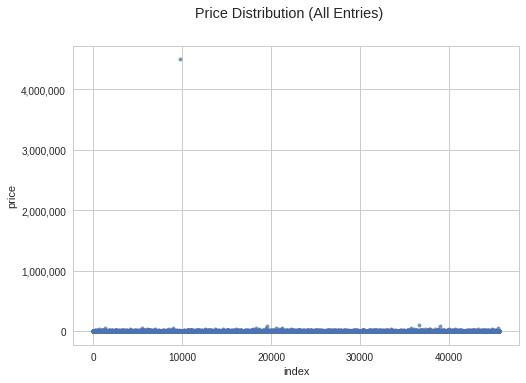

In [17]:
#look at price distribution, outliers exist
plt.scatter(x=range(df.shape[0]), y=df.price, marker='.', alpha=0.75)
plt.xlabel('index')
plt.ylabel('price')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.suptitle('Price Distribution (All Entries)')

In [18]:
#look at percentile to help remove outliers. Need to remove 99th percentile
np.percentile(df.price, [50, 75, 85, 90, 95, 97, 98, 99, 100])

array([  3.17000000e+03,   4.10000000e+03,   4.99500000e+03,
         5.60000000e+03,   6.70000000e+03,   8.00000000e+03,
         9.46200000e+03,   1.25000000e+04,   4.49000000e+06])

In [19]:
outliers = np.percentile(df.price, 99)

#removing price less than 99th percentile still leaves some outliers on the low end to be removed
df_clean = df[(df['price'] < outliers) & (df['price'] > 500)]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45181 entries, 0 to 46430
Data columns (total 22 columns):
bathrooms              45181 non-null float64
bedrooms               45181 non-null int64
building_id            45181 non-null object
closest_subway_dist    45181 non-null float64
created                45181 non-null object
description            45181 non-null object
display_address        45181 non-null object
features               45181 non-null object
interest_level         45181 non-null object
latitude               45181 non-null float64
listing_id             45181 non-null int64
longitude              45181 non-null float64
manager_id             45181 non-null object
photos                 45181 non-null object
pos                    45181 non-null object
price                  45181 non-null int64
street_address         45181 non-null object
int_level_num          45181 non-null int64
coords                 45181 non-null object
zipcode                45181 non-nul

<function matplotlib.pyplot.tight_layout>

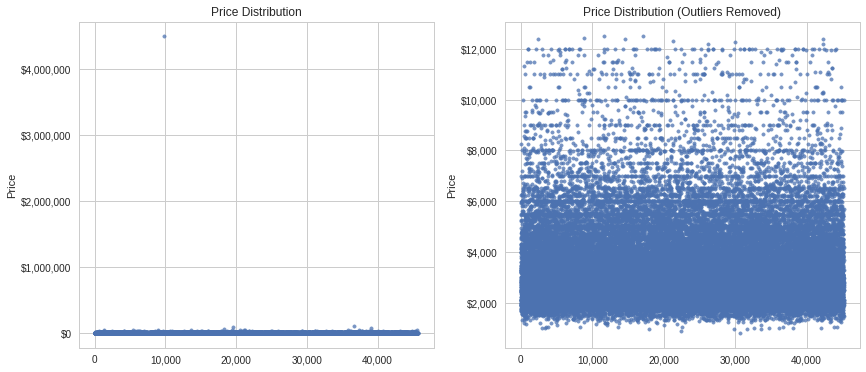

In [20]:
#create two price plots to show effect of removing outliers
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(x=range(df.shape[0]), y=df.price, marker='.', alpha=0.75)
#plt.xlabel('index')
plt.ylabel('Price')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Price Distribution')

plt.subplot(1,2,2)
plt.scatter(x=range(df_clean.shape[0]), y=df_clean.price, marker='.', alpha=0.75)
#plt.xlabel('')
plt.ylabel('Price')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Price Distribution (Outliers Removed)')
plt.tight_layout
#plt.savefig('figures/PricePlot.png', bbox_inches='tight')

In [21]:
#with price outliers removed, now look at locational outliers
geo_loc_df = df_clean[['latitude', 'longitude']]
geo_loc_df.describe()

,latitude,longitude
count,45181.000000,45181.000000
mean,40.751508,-73.972936
std,0.037196,0.026872
min,40.575800,-74.087300
25%,40.729600,-73.991600
50%,40.752100,-73.977900
75%,40.774000,-73.954600
max,40.910200,-73.749800


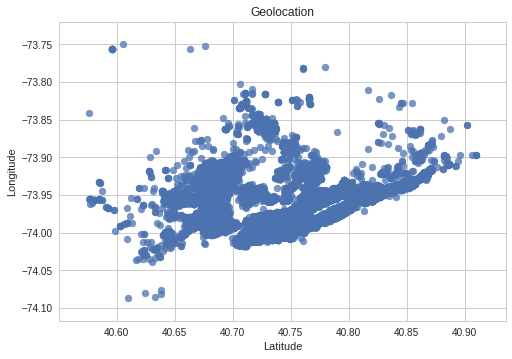

In [22]:
#plot lat-lon
plt.scatter(geo_loc_df.latitude, geo_loc_df.longitude, alpha=0.75)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geolocation')

In [23]:
#obvious outliers, remove max and min and 0's
#geo_loc_df = geo_loc_df[(geo_loc_df['longitude'] > geo_loc_df.longitude.min()) & 
#                        (geo_loc_df['latitude'] < geo_loc_df.latitude.max()) & 
#                        (geo_loc_df['longitude'] != 0) & 
#                        (geo_loc_df['latitude'] != 0)]

In [24]:
#geo_loc_df.describe()

In [25]:
#plot lat-lon to see if additional outliers exist, some still do ...
#plt.scatter(geo_loc_df.latitude, geo_loc_df.longitude, alpha=0.75)
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Geolocation')

In [26]:
#np.percentile(geo_loc_df.latitude, [0,1,2,3,4,5,95,96,97,98,99,100])

In [27]:
#np.percentile(geo_loc_df.longitude, [0,1,2,3,4,5,95,96,97,98,99,100])

In [28]:
#lat_min = np.percentile(geo_loc_df.latitude, 1)
#lat_max = np.percentile(geo_loc_df.latitude, 99)
#print(lat_min, lat_max)

In [29]:
#lon_min = np.percentile(geo_loc_df.longitude, 1)
#lon_max = np.percentile(geo_loc_df.longitude, 99)
#print(lon_min, lon_max)

In [30]:
#lat_min = np.percentile(geo_loc_df.latitude, 1)
#lat_max = np.percentile(geo_loc_df.latitude, 99)
#lon_min = np.percentile(geo_loc_df.longitude, 1)
#lon_max = np.percentile(geo_loc_df.longitude, 99)

#geo_clean = geo_loc_df[(geo_loc_df['latitude'] >= lat_min) & (geo_loc_df['longitude'] >= lon_min) & 
#                       (geo_loc_df['latitude'] <= lat_max) & (geo_loc_df['longitude'] <= lon_max)]
#geo_clean.describe()

In [31]:
#plt.scatter(geo_clean.latitude, geo_clean.longitude, alpha=0.75)
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Geolocation')

In [32]:
#remove lat-lon outliers from main data set
#df_clean = df_clean[(df_clean['latitude'] >= lat_min) & (df_clean['longitude'] >= lon_min) & 
#                       (df_clean['latitude'] <= lat_max) & (df_clean['longitude'] <= lon_max)]
#df_clean.info()

In [33]:
#create plots showing before/after of outlier removal
#plt.figure(figsize=(14,6))
#plt.subplot(1,2,1)
#plt.scatter(df.latitude, df.longitude, alpha=0.75)
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Geolocation')

#plt.subplot(1,2,2)
#plt.scatter(df_clean.latitude, df_clean.longitude, alpha=0.75)
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Geolocation (Outliers Removed)')

#plt.savefig('figures/locations.png', bbox_inches='tight')

In [34]:
#create list of unique lat-lon coordinates to make it quicker to find zip codes with geopy package
#coords_set = set(df_clean['coords'])
#convert list to data frame 
#coord_df = pd.DataFrame(list(coords_set))
#rename columns of newly created data frame
#coord_df.columns=['latitude', 'longitude']
#add new field that has lat-long as string
#coord_df['coords'] = coord_df.apply(lambda row: str(row['latitude']) + ', ' + str(row['longitude']),1)

In [35]:
#c1 = pd.read_csv('coord_df1')
#c2 = pd.read_csv('coord_df2')
#c3 = pd.read_csv('coord_df3')
#c4 = pd.read_csv('coord_df4')
#c5 = pd.read_csv('coord_df5')
#c6 = pd.read_csv('coord__rem_df1')
#c7 = pd.read_csv('coord__rem_df2')
#c8 = pd.read_csv('coord__rem_df3')
#c9 = pd.read_csv('coord__rem_df4')
#c10 = pd.read_csv('coord__rem_df5')

In [36]:
#tables = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10]

In [37]:
#cdf_all = pd.concat(tables)

In [38]:
#final_df = pd.merge(df_clean, cdf_final[['latitude', 'longitude', 'zipcode']],  how='left', on=['latitude','longitude'])

In [39]:
#final_df = final_df.dropna()
#final_df['zipcode'] = final_df['zipcode'].astype(int)
#final_df.head()

In [40]:
#df = pd.merge(df_clean, cdf_all, on='coords', how='left')
#new_df = pd.merge(df_clean, cdf_final,  how='left', on=['latitude','longitude'])

In [41]:
#new_df = pd.merge(df_clean, cdf_final,  how='left', on=['latitude','longitude'])
#new_df = new_df.dropna()
#new_df = new_df[new_df.zipcode != 'NY 10']
#new_df['zipcode'] = new_df['zipcode'].astype(int)

In [42]:
#coord_df_remain.info()

In [43]:
#coord_rem_df1 = coord_df_remain[:1500]           #done
#coord_rem_df2 = coord_df_remain[1500:2500]     # done
#coord_rem_df3 = coord_df_remain[2500:3500]     #done
#coord_rem_df4 = coord_df_remain[3500:4500]   #done
#coord_rem_df5 = coord_df_remain[4500:]

In [44]:
#function to take lat-lon coords and reverse locate the zip code
index=0
def get_zip(coord):
    from geopy.distance import vincenty
    from geopy.geocoders import Nominatim
    geolocator = Nominatim()
    global index
    index+=1 
    #print(index)
    try:
        g = geolocator.reverse(coord)
        print(index, coord, g.raw['address']['postcode'][:5])
        return g.raw['address']['postcode'][:5]
        time.sleep(1.25)   #geopy allows 1 pull per sec. If faster, then a 429 error occurs
    except GeocoderTimedOut:
        return get_zip(coord)
    except:
        print(index, coord, 'na')
        return ('na')

In [45]:
#creates new zipcode column using the coords column as an input into the get_zip function
#coord_rem_df5['zipcode'] = coord_rem_df5['coords'].apply(get_zip)

In [46]:
#coord_rem_df5.to_csv('coord__rem_df5')

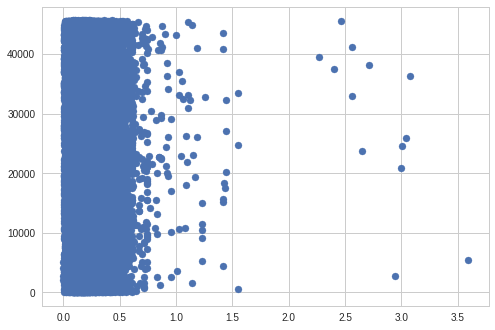

In [47]:
#look at subway data
plt.scatter(x=df.closest_subway_dist, y=range(df.shape[0]))
#outliers exist, obvious break at 2 miles or more, will remove points greater than 2 miles from subway

In [48]:
df_clean = df_clean[df_clean['closest_subway_dist'] < 2.0]

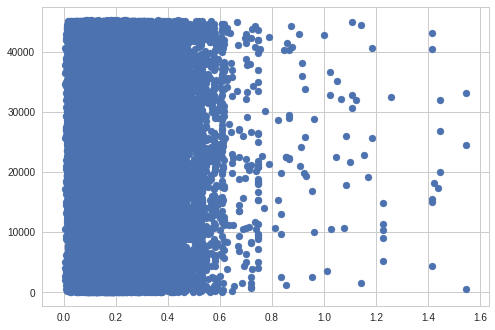

In [49]:
plt.scatter(x=df_clean.closest_subway_dist, y=range(df_clean.shape[0]))

<function matplotlib.pyplot.tight_layout>

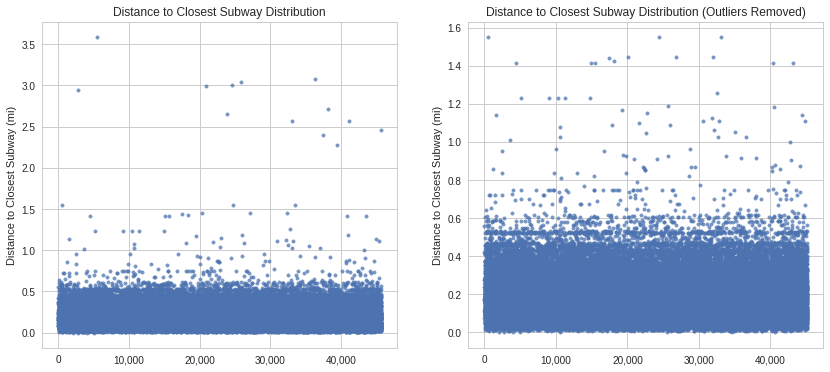

In [50]:
#create two subway distance plots to show effect of removing outliers
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(x=range(df.shape[0]), y=df.closest_subway_dist, marker='.', alpha=0.75)
#plt.xlabel('index')
plt.ylabel('Distance to Closest Subway (mi)')
ax = plt.gca()
#ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Distance to Closest Subway Distribution')

plt.subplot(1,2,2)
plt.scatter(x=range(df_clean.shape[0]), y=df_clean.closest_subway_dist, marker='.', alpha=0.75)
#plt.xlabel('')
plt.ylabel('Distance to Closest Subway (mi)')
ax = plt.gca()
#ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Distance to Closest Subway Distribution (Outliers Removed)')
plt.tight_layout
#plt.savefig('figures/SubwayDist.png', bbox_inches='tight')

In [51]:
bed_bath_build = df_clean[['building_id', 'bathrooms', 'bedrooms']]
bed_bath_build.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45168 entries, 0 to 46430
Data columns (total 3 columns):
building_id    45168 non-null object
bathrooms      45168 non-null float64
bedrooms       45168 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.6+ MB


In [52]:
bed_bath_build.describe()

,bathrooms,bedrooms
count,45168.000000,45168.000000
mean,1.189360,1.528317
std,0.448363,1.104657
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,2.000000
max,10.000000,8.000000


In [53]:
np.percentile(bed_bath_build.bathrooms, [10,25,50,75,90,95,96,97,98,99,100])

array([  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   3.,  10.])

In [54]:
#pd.crosstab(bed_bath_build.building_id, bed_bath_build.bathrooms, margins=True)
bed_bath_build.building_id[bed_bath_build['bathrooms'] <= 2].count()

44369

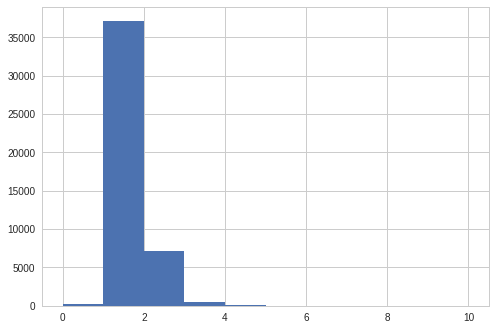

In [55]:
bed_bath_build.bathrooms.hist()

In [56]:
#outlier for bathrooms removed
df_clean = df_clean[df_clean['bathrooms'] < df_clean.bathrooms.max()]

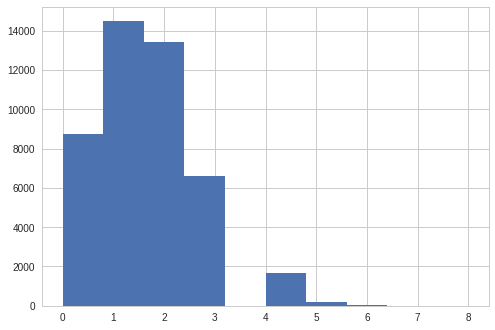

In [57]:
bed_bath_build.bedrooms.hist()

In [58]:
np.percentile(bed_bath_build.bedrooms, [10,25,50,75,90,95,96,97,98,99,100])

array([ 0.,  1.,  1.,  2.,  3.,  3.,  4.,  4.,  4.,  4.,  8.])

In [59]:
#outlier for bedrooms removed
df_clean = df_clean[df_clean['bedrooms'] < df_clean.bedrooms.max()]

In [60]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45165 entries, 0 to 46430
Data columns (total 22 columns):
bathrooms              45165 non-null float64
bedrooms               45165 non-null int64
building_id            45165 non-null object
closest_subway_dist    45165 non-null float64
created                45165 non-null object
description            45165 non-null object
display_address        45165 non-null object
features               45165 non-null object
interest_level         45165 non-null object
latitude               45165 non-null float64
listing_id             45165 non-null int64
longitude              45165 non-null float64
manager_id             45165 non-null object
photos                 45165 non-null object
pos                    45165 non-null object
price                  45165 non-null int64
street_address         45165 non-null object
int_level_num          45165 non-null int64
coords                 45165 non-null object
zipcode                45165 non-nul

In [61]:
#NOW READY FOR ANALYSIS OF VARIABLES

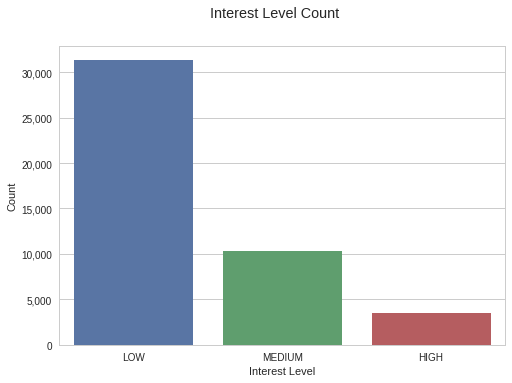

In [62]:
#look at target variable
sns.countplot(df_clean.interest_level, order=['LOW', 'MEDIUM', 'HIGH'])
plt.xlabel('Interest Level')
plt.ylabel('Count')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.suptitle('Interest Level Count')

#plt.savefig('figures/InterestLevelChart.png', bbox_inches='tight')

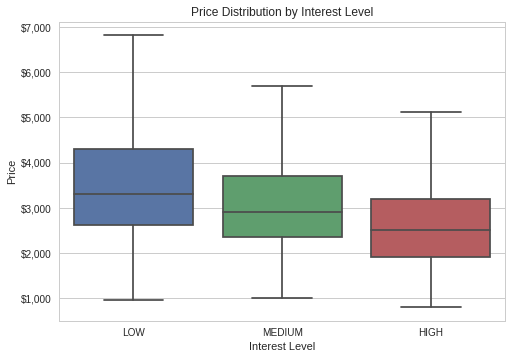

In [63]:
sns.boxplot(df_clean.interest_level, df_clean.price, order=['LOW', 'MEDIUM', 'HIGH'], showfliers=False)
plt.title('Price Distribution by Interest Level')
plt.xlabel('Interest Level')
plt.ylabel('Price')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#the lower the price, the higher the interest level. still a lot of over lap

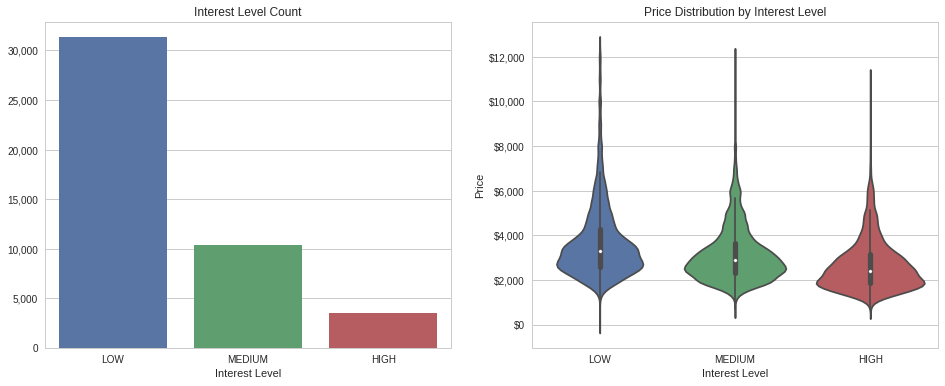

In [64]:
#create two plots examining interest level and interest_level vs price
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.countplot(df_clean.interest_level, order=['LOW', 'MEDIUM', 'HIGH'])
plt.xlabel('Interest Level')
plt.ylabel('')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Interest Level Count')

plt.subplot(1,2,2)
sns.violinplot(train.interest_level[train['price'] < outliers], train.price[train['price'] < outliers], jitter=True,
             order=['LOW', 'MEDIUM', 'HIGH'], alpha=0.6, marker='.')
plt.title('Price Distribution by Interest Level')
plt.xlabel('Interest Level')
plt.ylabel('Price')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#plt.savefig('figures/IntLevel-Price.png', bbox_inches='tight')

In [65]:
low_pct = len(df_clean[df_clean['interest_level'] == 'LOW']) / df_clean.shape[0]
high_pct = len(df_clean[df_clean['interest_level'] == 'HIGH']) / df_clean.shape[0]
print('low pct: ', low_pct, ' high pct: ', high_pct)

low pct:  0.6938115797630909  high pct:  0.07669655706852652


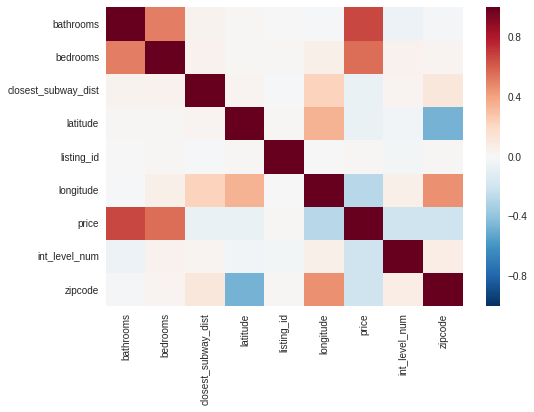

In [66]:
price_level_df = df_clean[['price', 'bedrooms']]
# calculate the correlation matrix
corr = df_clean.corr()
#corr
# plot the heatmap
sns.heatmap(corr)
        #xticklabels=corr.columns,
        #yticklabels=corr.columns)

In [67]:
df_clean.describe()

,bathrooms,bedrooms,closest_subway_dist,latitude,listing_id,longitude,price,int_level_num,zipcode
count,45165.000000,45165.000000,45165.000000,45165.000000,4.516500e+04,45165.000000,45165.000000,45165.000000,45165.000000
mean,1.189062,1.528019,0.202162,40.751525,7.023479e+06,-73.972957,3509.406399,0.382885,10176.688011
std,0.446180,1.103851,0.121569,0.037171,1.262287e+05,0.026736,1534.418355,0.624248,393.502930
min,0.000000,0.000000,0.002439,40.575800,6.811957e+06,-74.039500,800.000000,0.000000,10001.000000
25%,1.000000,1.000000,0.113447,40.729600,6.915370e+06,-73.991600,2500.000000,0.000000,10013.000000
50%,1.000000,1.000000,0.181660,40.752100,7.020098e+06,-73.977900,3150.000000,0.000000,10022.000000
75%,1.000000,2.000000,0.264730,40.774000,7.127766e+06,-73.954700,4034.000000,1.000000,10038.000000
max,4.500000,7.000000,1.547631,40.910200,7.742803e+06,-73.749800,12495.000000,2.000000,11694.000000


In [68]:
bath = pd.crosstab(df_clean.bathrooms, df_clean.interest_level, margins=True)
bath['Low Interest %'] = (bath['LOW']/bath['All']) * 100
bath['Medium Interest %'] = (bath['MEDIUM']/bath['All']) * 100
bath['High Interest %'] = (bath['HIGH']/bath['All']) * 100
bath#.iloc[:,4:7].style.format("{:1.%}")

#property listings with 2.5 baths or more are nearly 90% more likely to have a low interest rating. 
# 1 and 2 baths get a medium interest level almost a quarter of the time, while 1 and 2 baths have the highest 
# chance of getting a high interest left, albeit still low, at less than 10%.

#out of the 47,208 listings, more than 96% are for 1 or 2 bath properties. 

interest_level,HIGH,LOW,MEDIUM,All,Low Interest %,Medium Interest %,High Interest %
bathrooms,,,,,,,
0.0,1,274,4,279,98.207885,1.433692,0.358423
1.0,3072,24763,8713,36548,67.754734,23.839882,8.405385
1.5,0,548,37,585,93.675214,6.324786,0.000000
2.0,375,5034,1548,6957,72.358775,22.250970,5.390254
2.5,0,213,3,216,98.611111,1.388889,0.000000
3.0,14,415,55,484,85.743802,11.363636,2.892562
3.5,0,24,0,24,100.000000,0.000000,0.000000
4.0,2,64,5,71,90.140845,7.042254,2.816901
4.5,0,1,0,1,100.000000,0.000000,0.000000


In [69]:
bed = pd.crosstab(df_clean.bedrooms, df_clean.interest_level, margins=True)
bed['Low Interest %'] = (bed['LOW']/bed['All']) * 100
bed['Medium Interest %'] = (bed['MEDIUM']/bed['All']) * 100
bed['High Interest %'] = (bed['HIGH']/bed['All']) * 100
bed

#for bedrooms, studio (0) to 4 bedrooms appear most often for any interest level. 

interest_level,HIGH,LOW,MEDIUM,All,Low Interest %,Medium Interest %,High Interest %
bedrooms,,,,,,,
0,766,6045,1936,8747,69.109409,22.133303,8.757288
1,816,10841,2827,14484,74.848108,19.518089,5.633803
2,1196,9001,3239,13436,66.991664,24.106877,8.901459
3,548,4209,1853,6610,63.676248,28.033283,8.290469
4,136,1013,505,1654,61.245466,30.532044,8.222491
5,2,190,2,194,97.938144,1.030928,1.030928
6,0,37,2,39,94.871795,5.128205,0.000000
7,0,0,1,1,0.000000,100.000000,0.000000
All,3464,31336,10365,45165,69.381158,22.949186,7.669656


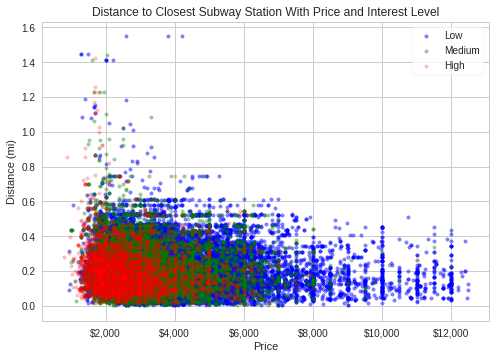

In [70]:
plt.scatter(df_clean.price[df_clean['interest_level'] == 'LOW'], 
            df_clean.closest_subway_dist[df_clean['interest_level'] == 'LOW'], 
            color='blue', alpha=0.5, marker='.', label='Low')
plt.scatter(df_clean.price[df_clean['interest_level'] == 'MEDIUM'], 
            df_clean.closest_subway_dist[df_clean['interest_level'] == 'MEDIUM'], 
            color='green', alpha=0.4, marker='.', label='Medium')
plt.scatter(df_clean.price[df_clean['interest_level'] == 'HIGH'], 
            df_clean.closest_subway_dist[df_clean['interest_level'] == 'HIGH'], 
            color='red', alpha=0.25, marker='.', label='High')
plt.title('Distance to Closest Subway Station With Price and Interest Level')
plt.legend(loc='best', frameon=True)
ax = plt.gca()
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.ylabel('Distance (mi)')
plt.xlabel('Price')
#plt.savefig('figures/SubDist_Price.png')

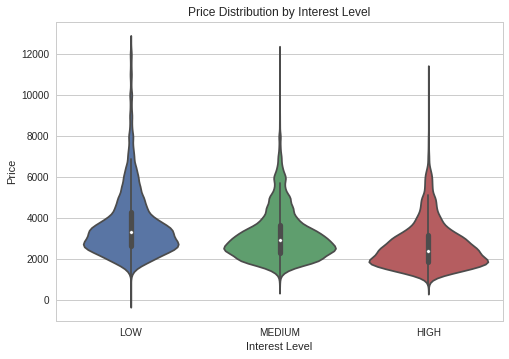

In [71]:
sns.violinplot(train.interest_level[train['price'] < outliers], train.price[train['price'] < outliers], jitter=True,
             order=['LOW', 'MEDIUM', 'HIGH'], alpha=0.6, marker='.')
plt.title('Price Distribution by Interest Level')
plt.ylabel('Price')
plt.xlabel('Interest Level')

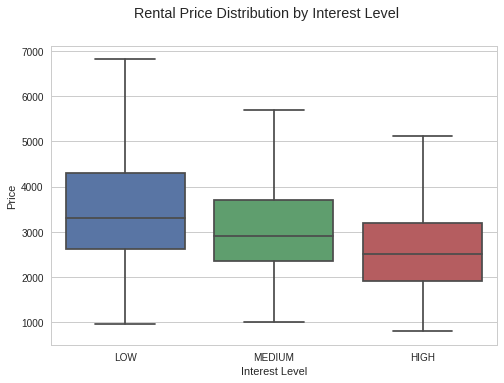

In [72]:
sns.boxplot(df_clean.interest_level, df_clean.price, order=['LOW', 'MEDIUM', 'HIGH'], showfliers=False)
plt.suptitle('Rental Price Distribution by Interest Level')
plt.xlabel('Interest Level')
plt.ylabel('Price')

(array([  9.47500000e+03,   1.57520000e+04,   1.46230000e+04,
          7.27600000e+03,   1.92900000e+03,   2.47000000e+02,
          4.60000000e+01,   4.00000000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 8 Patch objects>)

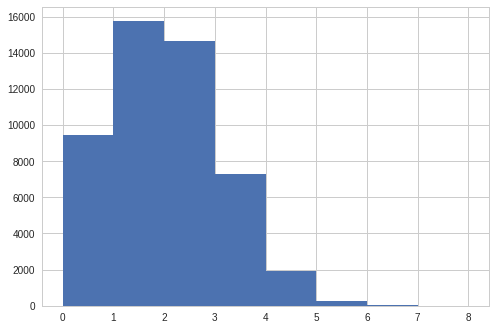

In [73]:
plt.hist(x=train.bedrooms.dropna(), bins=8)

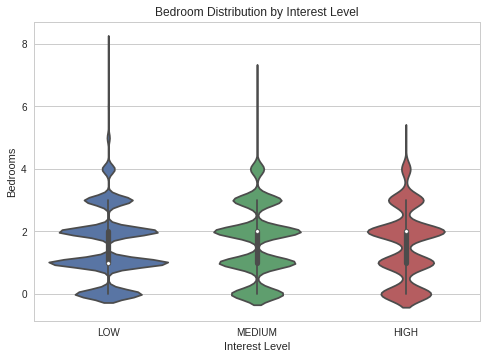

In [74]:
sns.violinplot(train.interest_level, train.bedrooms, jitter=True,
             order=['LOW', 'MEDIUM', 'HIGH'], alpha=0.6, marker='.')
plt.title('Bedroom Distribution by Interest Level')
plt.ylabel('Bedrooms')
plt.xlabel('Interest Level')

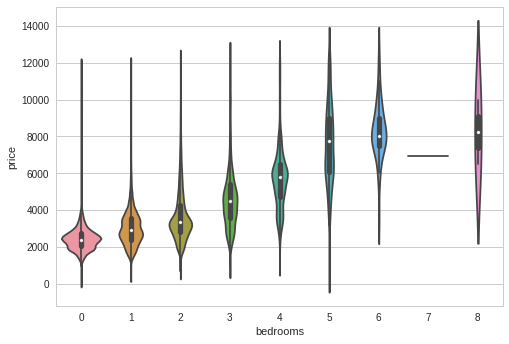

In [75]:
sns.violinplot(train.bedrooms[train['price'] < outliers], train.price[train['price'] < outliers],
              jitter=True, alpha=0.6, marker='.')

(array([  3.13000000e+02,   4.00670000e+04,   7.93700000e+03,
          8.15000000e+02,   1.88000000e+02,   2.50000000e+01,
          5.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

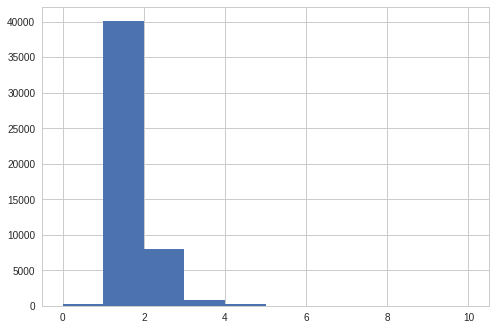

In [76]:
plt.hist(x=train.bathrooms.dropna(), bins=10)

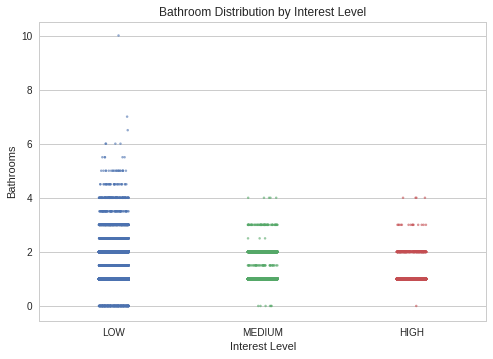

In [77]:
sns.stripplot(train.interest_level, train.bathrooms, jitter=True,
             order=['LOW', 'MEDIUM', 'HIGH'], alpha=0.6, marker='.')
plt.title('Bathroom Distribution by Interest Level')
plt.ylabel('Bathrooms')
plt.xlabel('Interest Level')

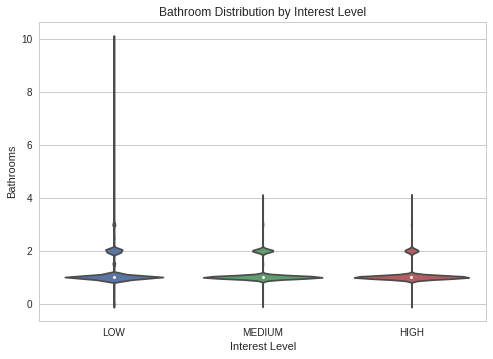

In [78]:
sns.violinplot(train.interest_level, train.bathrooms,
             order=['LOW', 'MEDIUM', 'HIGH'], alpha=0.6)
plt.title('Bathroom Distribution by Interest Level')
plt.ylabel('Bathrooms')
plt.xlabel('Interest Level')

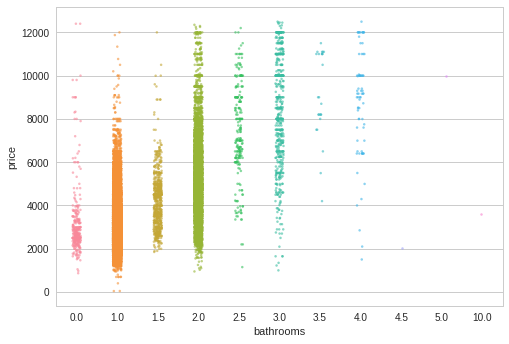

In [79]:
sns.stripplot(train.bathrooms[train['price'] < outliers], train.price[train['price'] < outliers],
              jitter=True, alpha=0.6, marker='.')

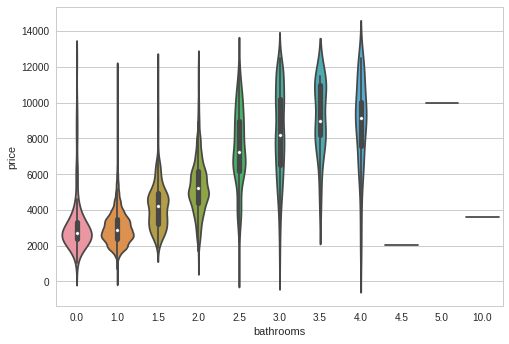

In [80]:
sns.violinplot(train.bathrooms[train['price'] < outliers], train.price[train['price'] < outliers], alpha=0.6)

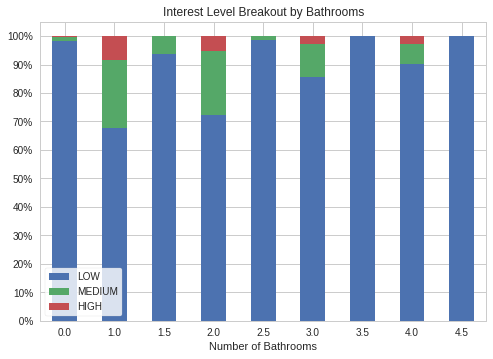

In [81]:
plt.figure(figsize=(16,6))

bath_plt = pd.crosstab(df_clean.bathrooms, df_clean.interest_level)[['LOW', 'MEDIUM', 'HIGH']]
bath_plt.div(bath_plt.sum(1), 0).plot(kind='bar', stacked=True)
plt.xlabel('Number of Bathrooms')
plt.legend(loc='lower left', frameon=True)
plt.title('Interest Level Breakout by Bathrooms')
plt.yticks(np.arange(0,1.1,.1))
plt.xticks(rotation=0)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:2.0f}%".format(x*100)))
#plt.savefig('figures/Bath_all.png')

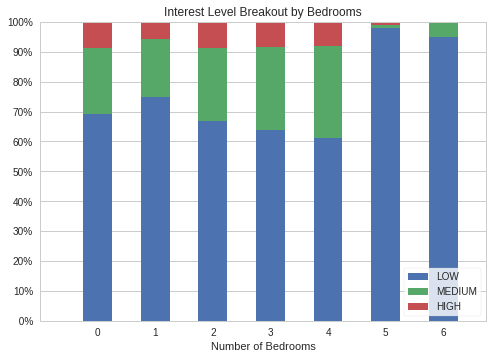

In [82]:
bed_plt = pd.crosstab(df_clean.bedrooms, df_clean.interest_level)[['LOW', 'MEDIUM', 'HIGH']]
bed_plt.div(bed_plt.sum(1), 0).plot(kind='bar', stacked=True)
plt.xlabel('Number of Bedrooms')
legend = plt.legend(loc='lower right', frameon=True)
plt.title('Interest Level Breakout by Bedrooms')
plt.yticks(np.arange(0,1.1,.1))
plt.axis([-1,6.75,0,1])
plt.xticks(rotation=0)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:2.0f}%".format(x*100)))
#plt.savefig('figures/Bed_all.png')

In [83]:
group_neigh = df_clean.groupby('neighborhood').neighborhood.count().nlargest(10)
list_top_neigh = list(group_neigh.index)
top_neigh_df = df_clean[df_clean['neighborhood'].isin(list_top_neigh)]

In [84]:
neigh = df_clean.groupby('neighborhood').neighborhood.count()
len(list(neigh.index))

36

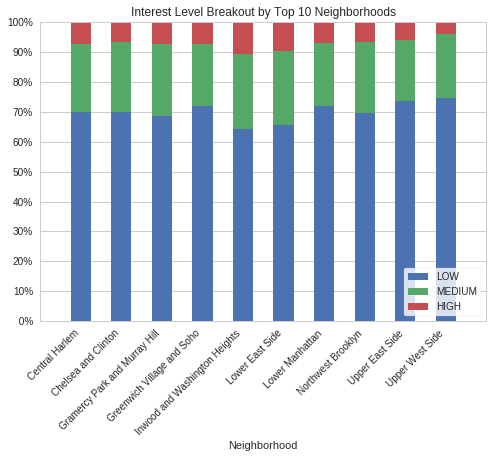

In [85]:
plt.figure(figsize=(30,12))
#top_neigh_df = df_clean.sort_values('interest_level')
neigh_plt = pd.crosstab(top_neigh_df.neighborhood, top_neigh_df.interest_level)[['LOW', 'MEDIUM', 'HIGH']]
neigh_plt.div(neigh_plt.sum(1), 0).plot(kind='bar', stacked=True)
plt.xlabel('Neighborhood')
legend = plt.legend(loc='lower right', frameon=True)
plt.title('Interest Level Breakout by Top 10 Neighborhoods')
plt.yticks(np.arange(0,1.1,.1))
plt.axis([-1,10,0,1])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:2.0f}%".format(x*100)))
#plt.savefig('figures/Top10Neigh.png')

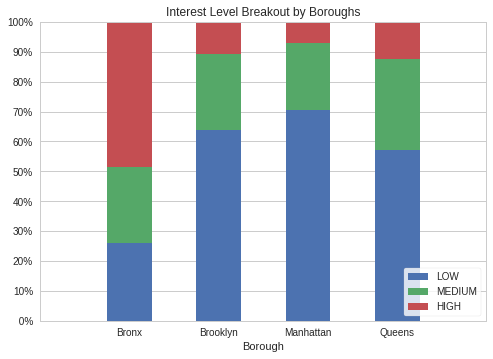

In [153]:
plt.figure(figsize=(30,12))
bor_plt = pd.crosstab(df_clean.borough, df_clean.interest_level)[['LOW', 'MEDIUM', 'HIGH']]
bor_plt.div(bor_plt.sum(1), 0).plot(kind='bar', stacked=True)
plt.xlabel('Borough')
legend = plt.legend(loc='lower right', frameon=True)
plt.title('Interest Level Breakout by Boroughs')
plt.yticks(np.arange(0,1.1,.1))
plt.axis([-1,4,0,1])
plt.xticks(rotation=0, ha='center')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:2.0f}%".format(x*100)))
#plt.savefig('figures/Borough.png')

In [86]:
#dfH = df_clean[df_clean['interest_level'] == 'HIGH']
#dfM = df_clean[df_clean['interest_level'] == 'MEDIUM']
#dfL = df_clean[df_clean['interest_level'] == 'LOW']

In [87]:
m = folium.Map(location=[df_clean['latitude'].mean(),df_clean['longitude'].mean()], tiles='Stamen Terrain', 
                            zoom_start=12)


In [ ]:
#dfL.apply(lambda row:folium.CircleMarker(location=[row.latitude, row.longitude],
#                                       radius=15, color='blue', popup=row.display_address).add_to(m), axis=1)

#dfM.apply(lambda row:folium.CircleMarker(location=[row.latitude, row.longitude], 
#                                        radius=15, color='green').add_to(m), axis=1)

#dfH.apply(lambda row:folium.CircleMarker(location=[row.latitude, row.longitude],
#                                        radius=15, color='red').add_to(m), axis=1)

#m

/home/nick/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/nick/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nick/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


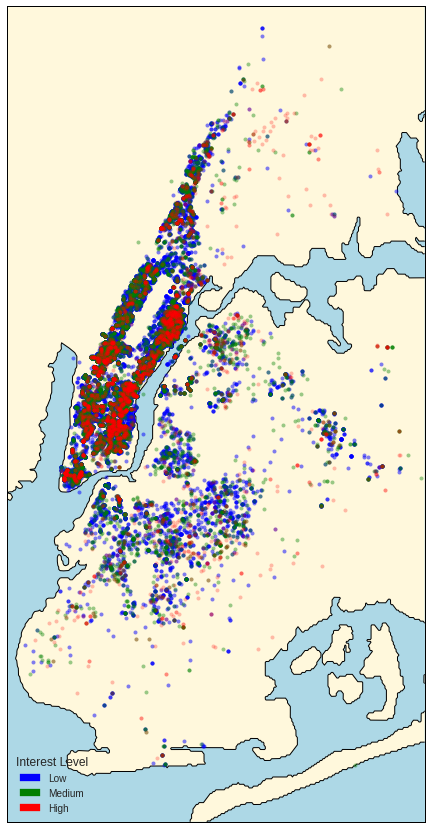

In [154]:
fig, ax = plt.subplots(figsize=(10,15))

west, south, east, north = -74.05, 40.55, -73.8, 40.92
m = Basemap(resolution='f', # 'c'rude, 'l'ow, 'i'ntermediate, 'h'igh, 'f'ull or None
            projection='merc', lat_ts=south,
            llcrnrlon=west, llcrnrlat=south, urcrnrlon=east, urcrnrlat=north)

#download open streetmap data from download.geofabrik.de
m.drawmapboundary(fill_color='lightblue')  #color of seas/oceans
m.fillcontinents(color='cornsilk')  #color of landmasses and lakes, lake_color=
m.drawcoastlines()
m.drawcountries()
    
#m.readshapefile('gis.osm_roads_free_1.shp', 'osm_roads_free_1')    
    
x,y = m(df_clean.longitude[df_clean['interest_level'] == 'HIGH'].values, 
        df_clean.latitude[df_clean['interest_level'] == 'HIGH'].values)
a,b = m(df_clean.longitude[df_clean['interest_level'] == 'MEDIUM'].values,
        df_clean.latitude[df_clean['interest_level'] == 'MEDIUM'].values)
c,d = m(df_clean.longitude[df_clean['interest_level'] == 'LOW'].values,
        df_clean.latitude[df_clean['interest_level'] == 'LOW'].values)

#setting the legend for the plot using patch
lo = mpatches.Patch(color='blue', label='Low')
med = mpatches.Patch(color='green', label='Medium')
hi = mpatches.Patch(color='red', label='High')
plt.legend(handles=[lo, med, hi],title='Interest Level', loc=3)

m.plot(c, d, 'bo', markersize=4, alpha=0.5)
m.plot(a, b, 'go', markersize=4, alpha=0.4)
m.plot(x, y, 'ro', markersize=4, alpha=0.25)
m
#plt.savefig('figures/Map.png')